# Finding the MRI brain tumor detection dataset

Let's find the dataset in this link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Import packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [14]:
# Check if data directory exists
import os

data_path = "./data/brain_tumor_dataset"
if not os.path.exists(data_path):
    print("❌ ERROR: Data directory not found!")
    print(f"Expected location: {os.path.abspath(data_path)}")
    print("\n📥 Please download the dataset from:")
    print("https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection")
    print(f"\n📁 Extract it to: {os.path.abspath(data_path)}")
    print("\nExpected structure:")
    print("  data/")
    print("    brain_tumor_dataset/")
    print("      yes/    (tumor images)")
    print("      no/     (healthy images)")
else:
    yes_path = os.path.join(data_path, "yes")
    no_path = os.path.join(data_path, "no")
    
    yes_count = len(glob.glob(os.path.join(yes_path, "*.jpg")))
    no_count = len(glob.glob(os.path.join(no_path, "*.jpg")))
    
    print(f"✅ Data directory found!")
    print(f"   Tumor images (yes): {yes_count}")
    print(f"   Healthy images (no): {no_count}")
    
    if yes_count == 0 or no_count == 0:
        print("\n⚠️ WARNING: Some image folders are empty!")


✅ Data directory found!
   Tumor images (yes): 154
   Healthy images (no): 91


## Reading the Images

In [15]:
tumor = []
healthy = []
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [16]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [17]:
healthy.shape

(91, 128, 128, 3)

In [18]:
tumor.shape

(154, 128, 128, 3)

In [6]:
np.random.choice(10, 5, replace=False)

array([6, 0, 1, 3, 4], dtype=int32)

# Visualizing Brain MRI Images

In [7]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        
        

    

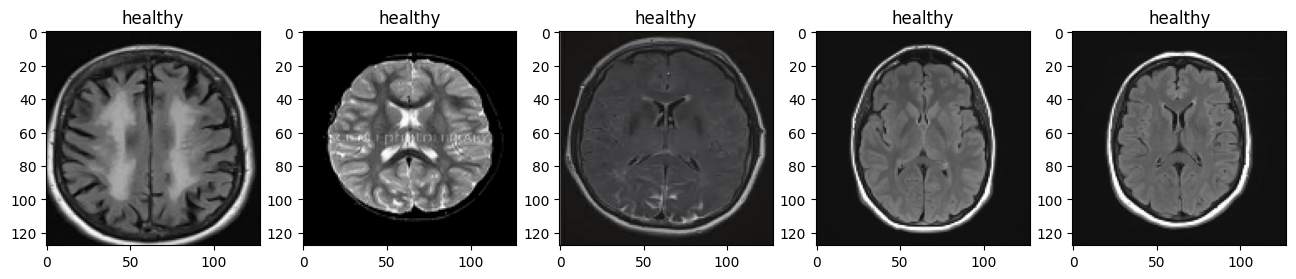

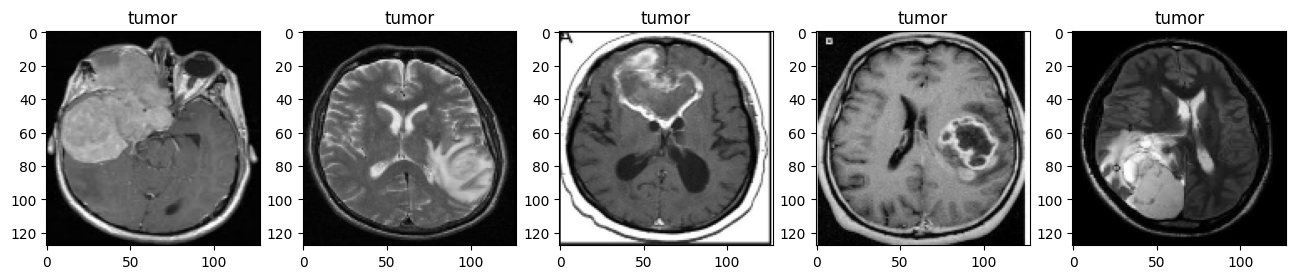

In [19]:
plot_random(healthy, tumor, num=5)

 # Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [20]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creating MRI cutom dataset class 

In [21]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [22]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

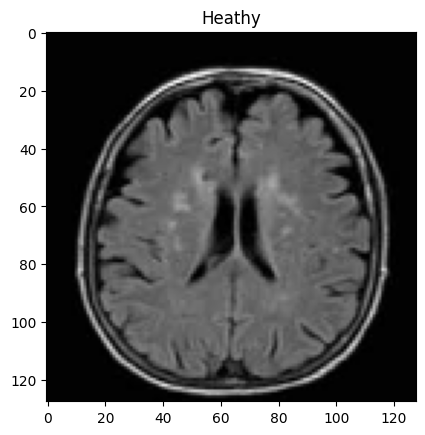

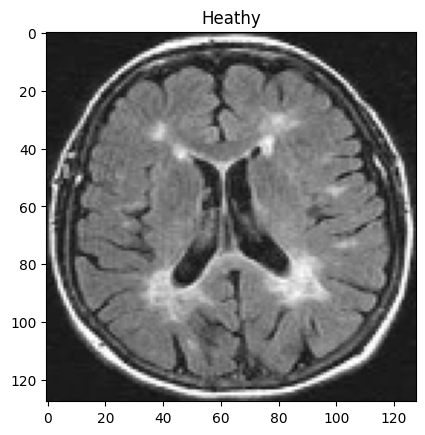

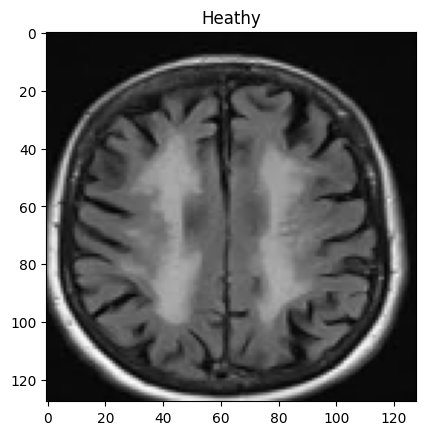

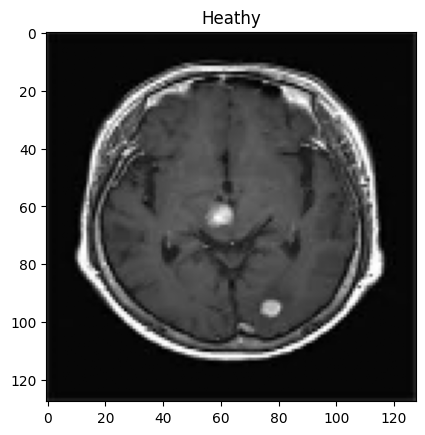

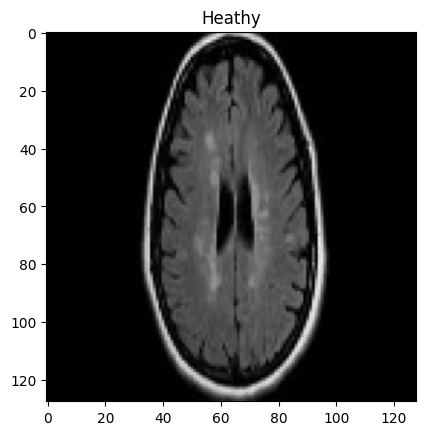

In [23]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a model

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

# Some Basics of Training and Evaluation in Pytorch

## model.eval()

- Used particularly for inference **NOTHING to DO with gradients!!!**
- changes the forward() behaviour of the module it is called up on eg, it disables dropout and has batch norm use the entire population statistics. This is necessary for inference

## model.train()

- Brings drop out and batch norm to action (i.e., train mode). 
- Gradients are computed

## numpy array vs tensor

The difference between a NumPy array and a tensor is that the tensors are backed by the accelerator memory like GPU and they are immutable, unlike NumPy arrays. You can never update a tensor but create a new one. If you are into machine learning or going to be into it, A Tensor is a suitable choice if you are going to use GPU. A tensor can reside in accelerator’s memory.

- The numpy arrays are the core functionality of the numpy package designed to support faster mathematical operations. Unlike python’s inbuilt list data structure, they can only hold elements of a single data type. Library like pandas which is used for data preprocessing is built around the numpy array. **Pytorch tensors are similar to numpy arrays, but can also be operated on CUDA-capable Nvidia GPU.**
- Numpy arrays are mainly used in typical machine learning algorithms (such as k-means or Decision Tree in scikit-learn) whereas pytorch tensors are mainly used in deep learning which requires heavy matrix computation.
- Unlike numpy arrays, while creating pytorch tensor, it also accepts two other arguments called the device_type (whether the computation happens on CPU or GPU) and the requires_grad (which is used to compute the derivatives).

## torch.tensor vs. torch.cuda.tensor

he key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU.

In [25]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.5539, 0.9244, 0.1695, 0.3893, 0.6959, 0.5490, 0.2218, 0.3977, 0.3829,
        0.5947]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.5539, 0.9244, 0.1695, 0.3893, 0.6959, 0.5490, 0.2218, 0.3977, 0.3829,
        0.5947]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.3068, 0.8544, 0.0287, 0.1515, 0.4842, 0.3014, 0.0492, 0.1581, 0.1466,
        0.3537])


As the underlying hardware interface is completely different, CPU Tensors are just compatible with CPU Tensor and vice versa GPU Tensors are just compatible to GPU Tensors.

### In which scenario is torch.cuda.Tensor() necessary?

When you want to use GPU acceleration (which is much faster in most cases) for your program, you need to use torch.cuda.Tensor, but you have to make sure that ALL tensors you are using are CUDA Tensors, mixing is not possible here.

### tensor.cpu().detach().numpy(): Convert Pytorch tensor to Numpy array

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.
.cpu() returns a copy of this object in CPU memory.

# Evaluate a New-Born Neural Network!

In [38]:
mri_dataset = MRI()
mri_dataset.normalize()
# Automatically use GPU if available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)

Using device: cpu


In [64]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [65]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    


In [66]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [67]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [68]:
accuracy_score(y_true, threshold(outputs))

0.7959183673469388

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

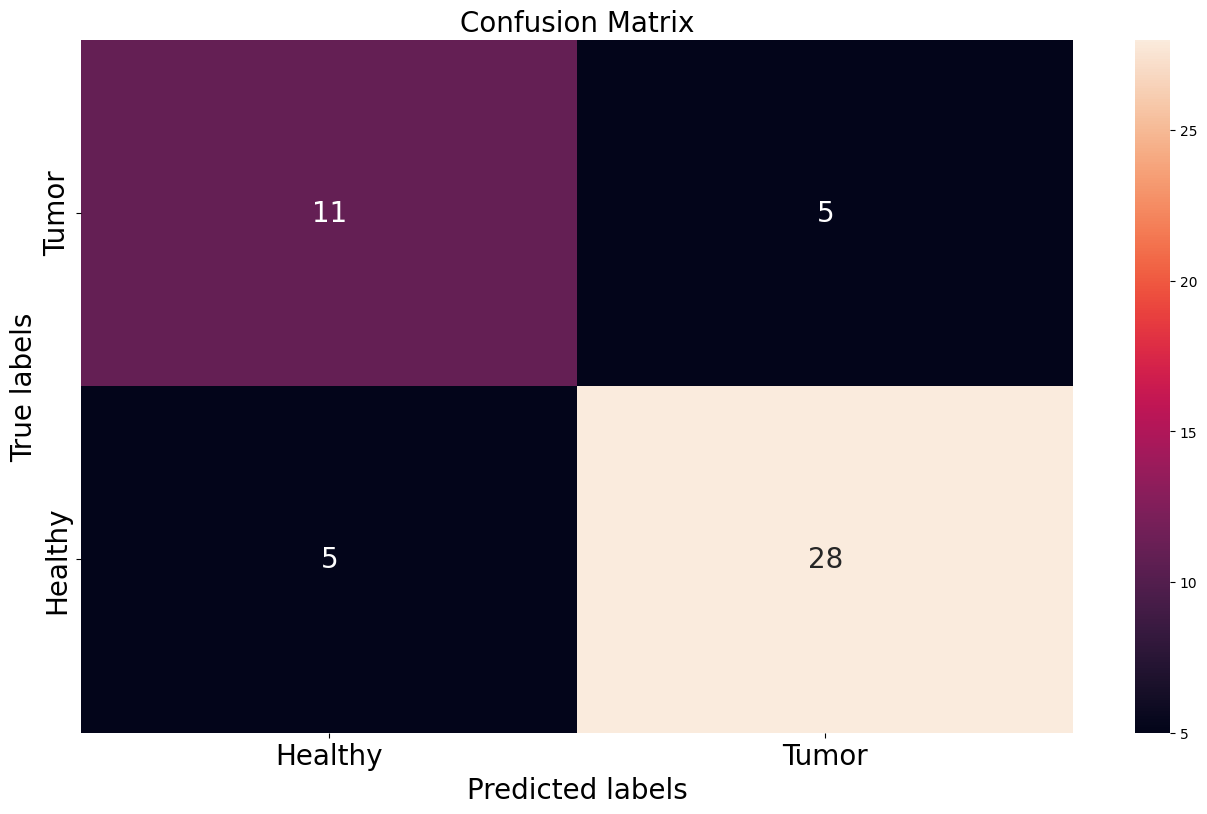

In [69]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

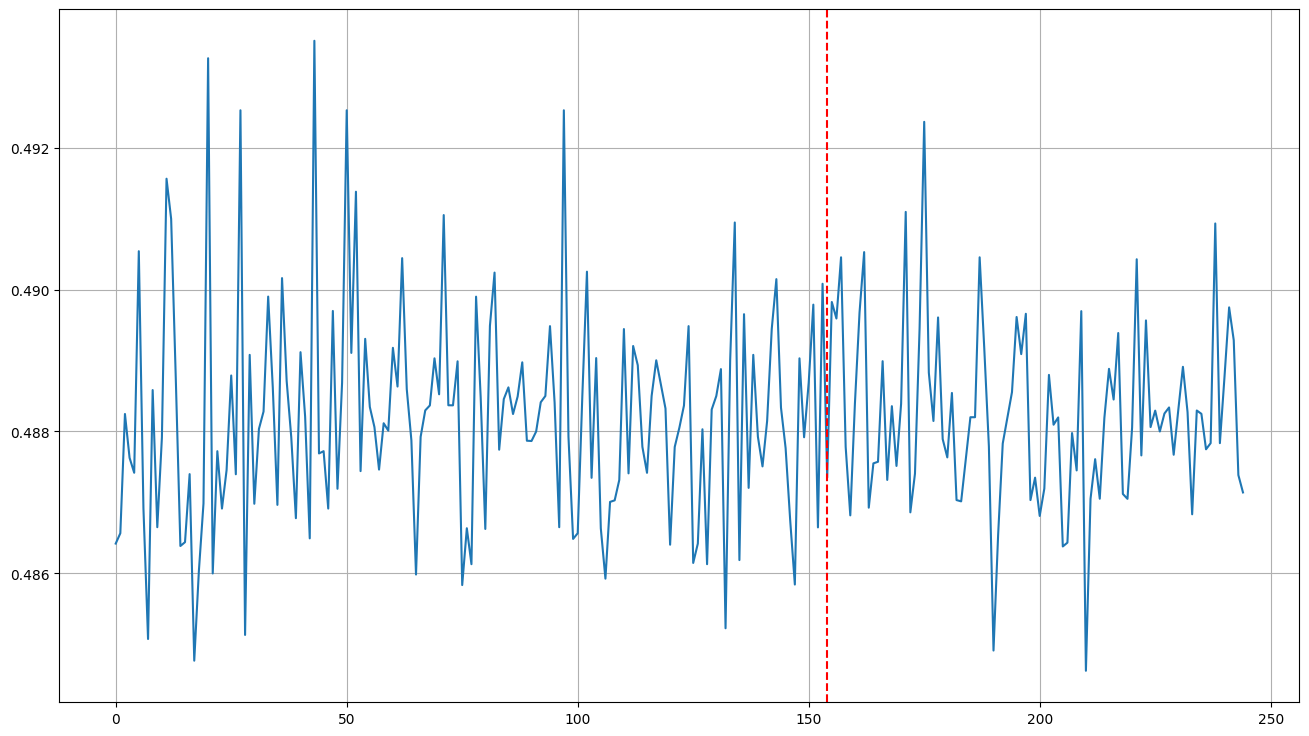

In [35]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [70]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [71]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 2.160740
Train Epoch: 20	Loss: 1.754792
Train Epoch: 20	Loss: 1.754792
Train Epoch: 30	Loss: 1.058885
Train Epoch: 30	Loss: 1.058885
Train Epoch: 40	Loss: 1.176247
Train Epoch: 40	Loss: 1.176247
Train Epoch: 50	Loss: 0.919493
Train Epoch: 50	Loss: 0.919493
Train Epoch: 60	Loss: 0.572419
Train Epoch: 60	Loss: 0.572419
Train Epoch: 70	Loss: 0.416315
Train Epoch: 70	Loss: 0.416315
Train Epoch: 80	Loss: 0.321967
Train Epoch: 80	Loss: 0.321967
Train Epoch: 90	Loss: 0.260032
Train Epoch: 90	Loss: 0.260032
Train Epoch: 100	Loss: 0.163670
Train Epoch: 100	Loss: 0.163670
Train Epoch: 110	Loss: 0.115620
Train Epoch: 110	Loss: 0.115620
Train Epoch: 120	Loss: 0.093030
Train Epoch: 120	Loss: 0.093030
Train Epoch: 130	Loss: 0.076754
Train Epoch: 130	Loss: 0.076754
Train Epoch: 140	Loss: 0.077099
Train Epoch: 140	Loss: 0.077099
Train Epoch: 150	Loss: 0.069280
Train Epoch: 150	Loss: 0.069280
Train Epoch: 160	Loss: 0.059351
Train Epoch: 160	Loss: 0.059351
Train Epoch: 170	Loss: 0.

# Evaluate a smart model

In [72]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [73]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

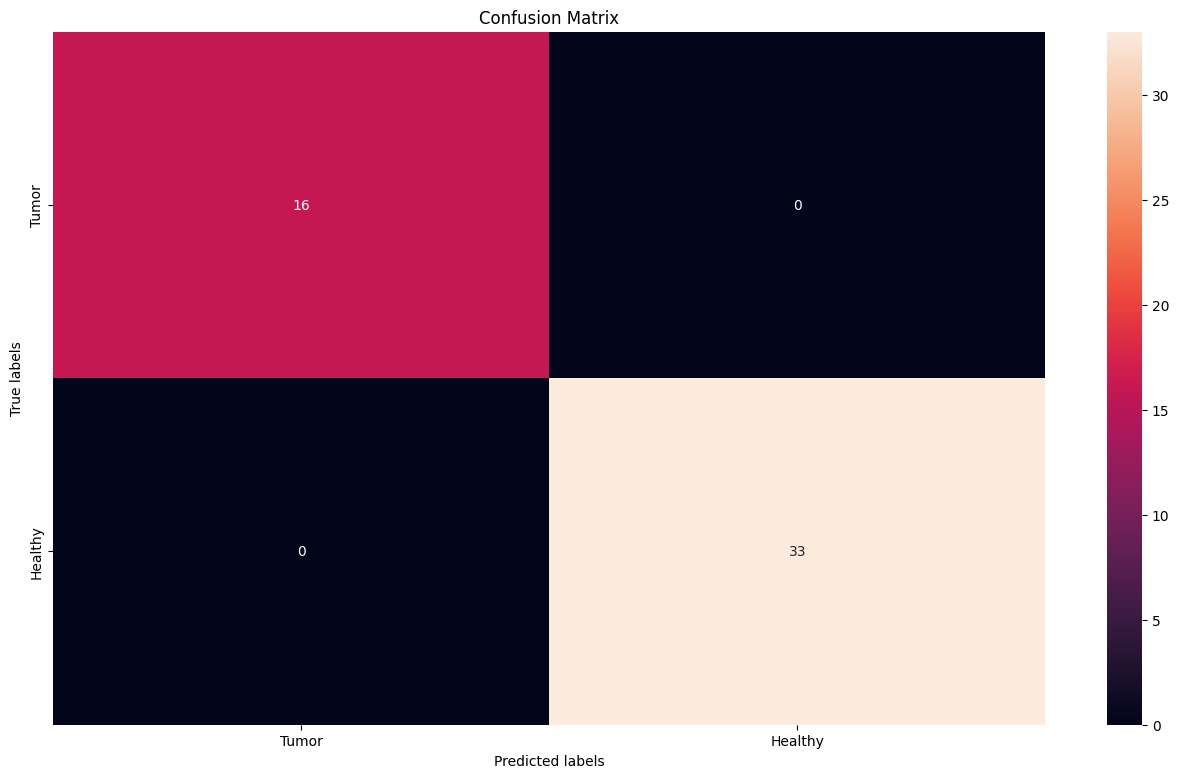

In [74]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

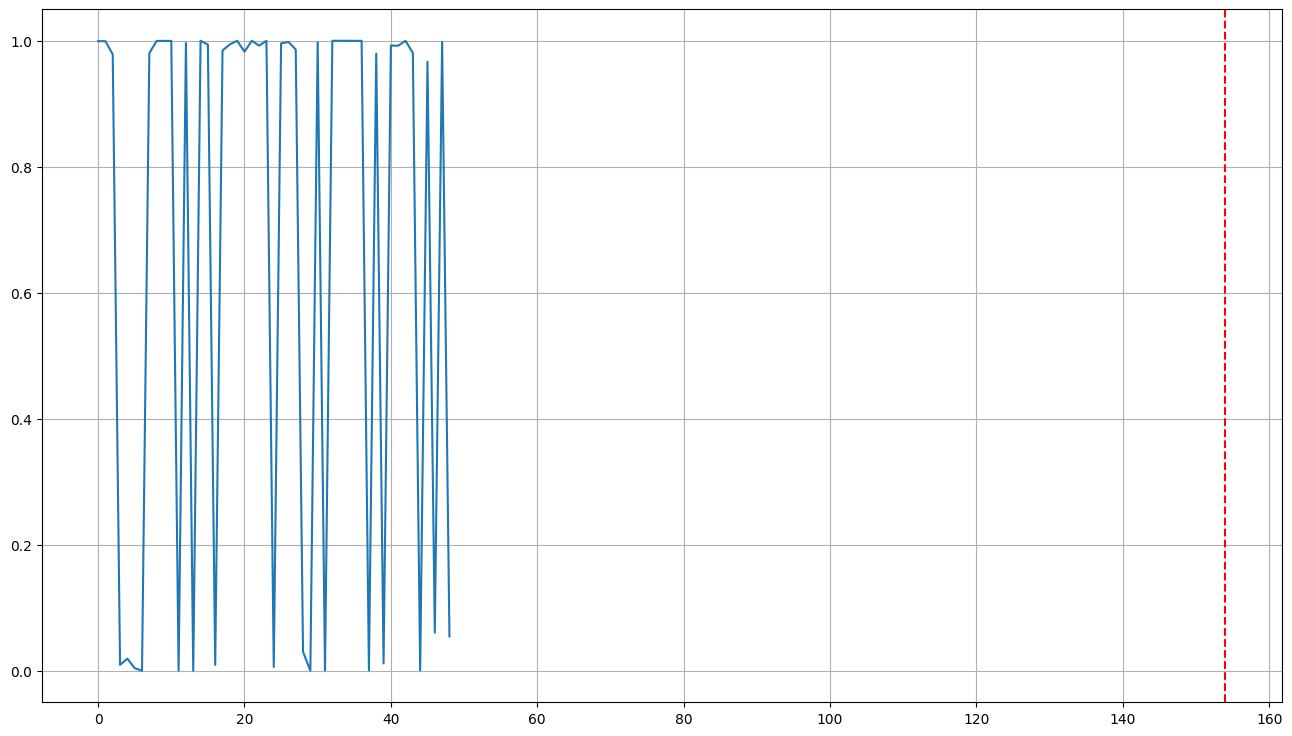

In [75]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [43]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [44]:
no_of_layers = 0
conv_layers = []

In [45]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [46]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [47]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

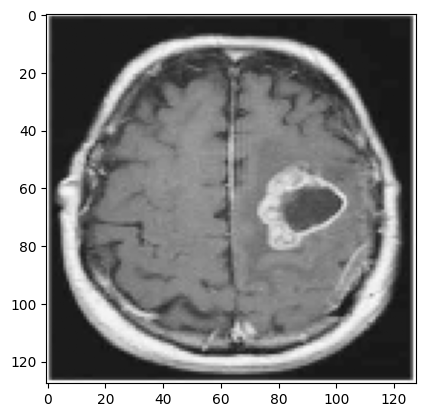

In [48]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [49]:
img = torch.from_numpy(img).to(device)

In [50]:
img.shape

torch.Size([3, 128, 128])

In [51]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [52]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


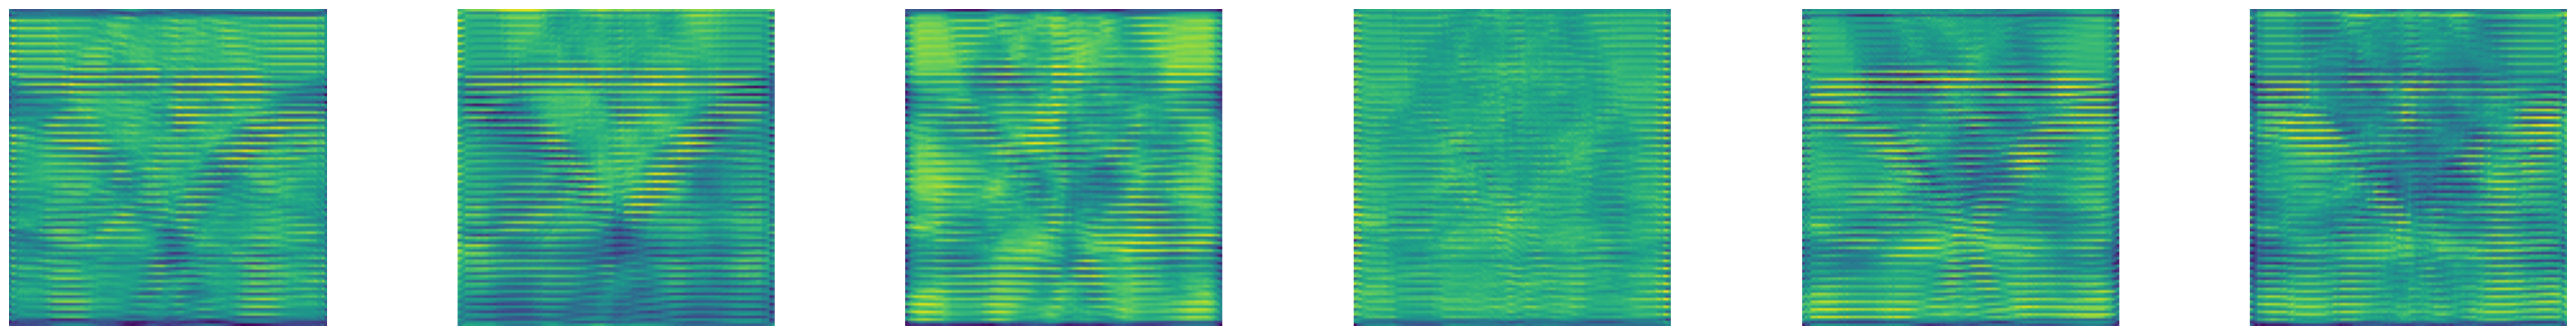

Layer  2


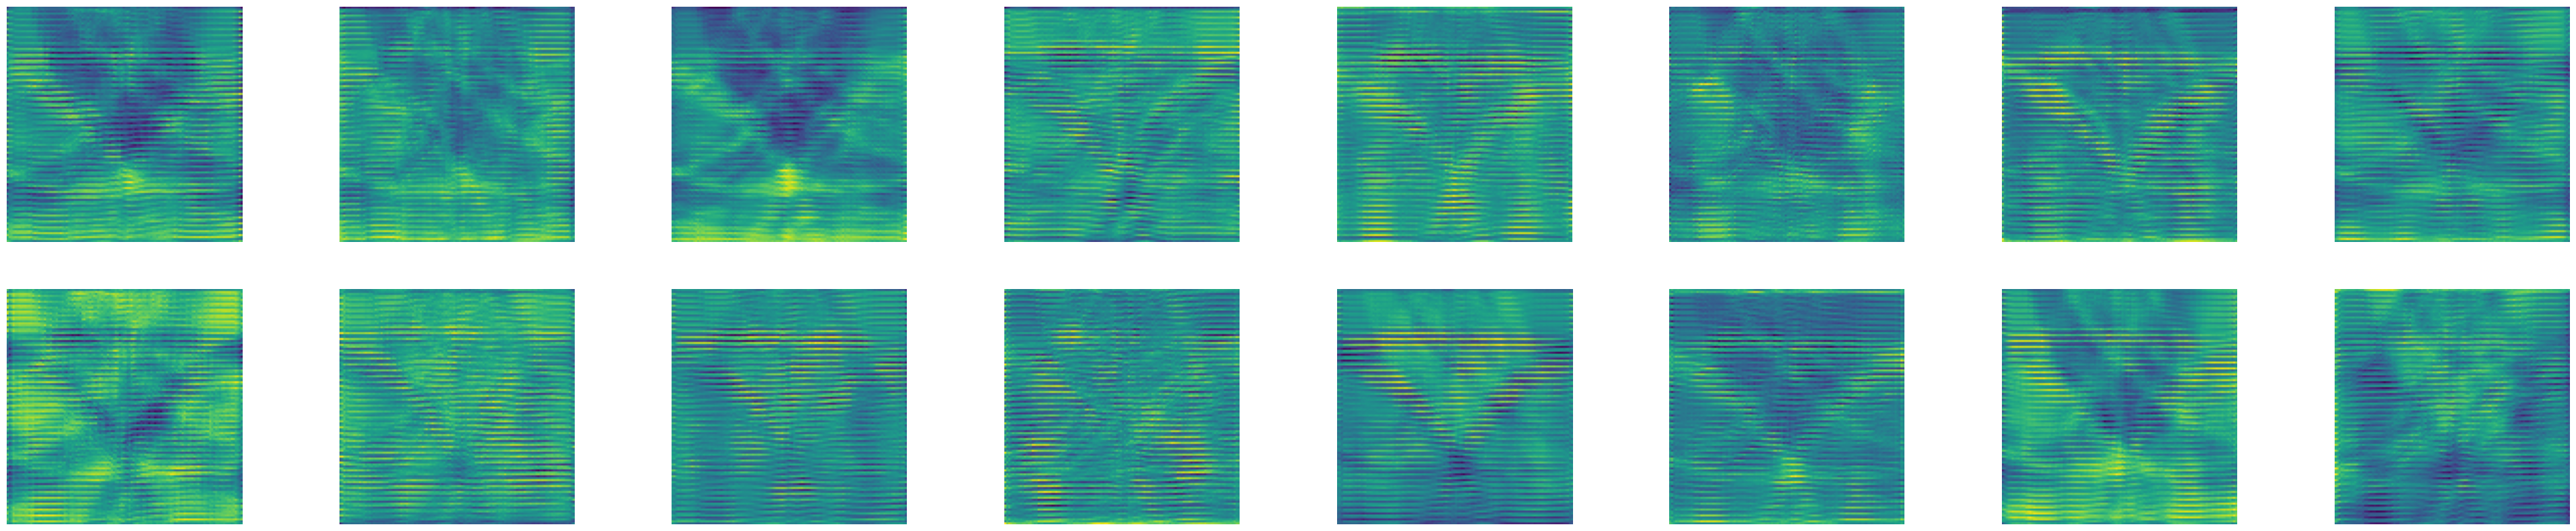

In [53]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Are We Over-fitting?

## Preparing a validation set: We need to change the MRI dataset slightly!

We will need to make changes to our **MRI dataset class**:

- Define a function to divide the data into train and validation sets
- Define a variable called **mode** to determine whether we are interested in the training OR validation data
- Change __len()__ and __getitem__() functions and conditioned over the variable **mode**

In [54]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [55]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

# Are we overfitting?

In [56]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [57]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [58]:
# Automatically use GPU if available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)

Using device: cpu


In [59]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [61]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [62]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.649425	Val Loss: 0.590117
Train Epoch: 20	Train Loss: 0.603053	Val Loss: 0.576477
Train Epoch: 20	Train Loss: 0.603053	Val Loss: 0.576477
Train Epoch: 30	Train Loss: 0.541450	Val Loss: 0.544717
Train Epoch: 30	Train Loss: 0.541450	Val Loss: 0.544717
Train Epoch: 40	Train Loss: 0.531173	Val Loss: 0.557936
Train Epoch: 40	Train Loss: 0.531173	Val Loss: 0.557936
Train Epoch: 50	Train Loss: 0.481449	Val Loss: 0.556006
Train Epoch: 50	Train Loss: 0.481449	Val Loss: 0.556006
Train Epoch: 60	Train Loss: 0.500424	Val Loss: 0.585091
Train Epoch: 60	Train Loss: 0.500424	Val Loss: 0.585091
Train Epoch: 70	Train Loss: 0.475840	Val Loss: 0.613813
Train Epoch: 70	Train Loss: 0.475840	Val Loss: 0.613813
Train Epoch: 80	Train Loss: 0.461479	Val Loss: 0.617119
Train Epoch: 80	Train Loss: 0.461479	Val Loss: 0.617119
Train Epoch: 90	Train Loss: 0.430379	Val Loss: 0.646217
Train Epoch: 90	Train Loss: 0.430379	Val Loss: 0.646217
Train Epoch: 100	Train Loss: 0.424381	Val Loss: 

Text(0, 0.5, 'Loss')

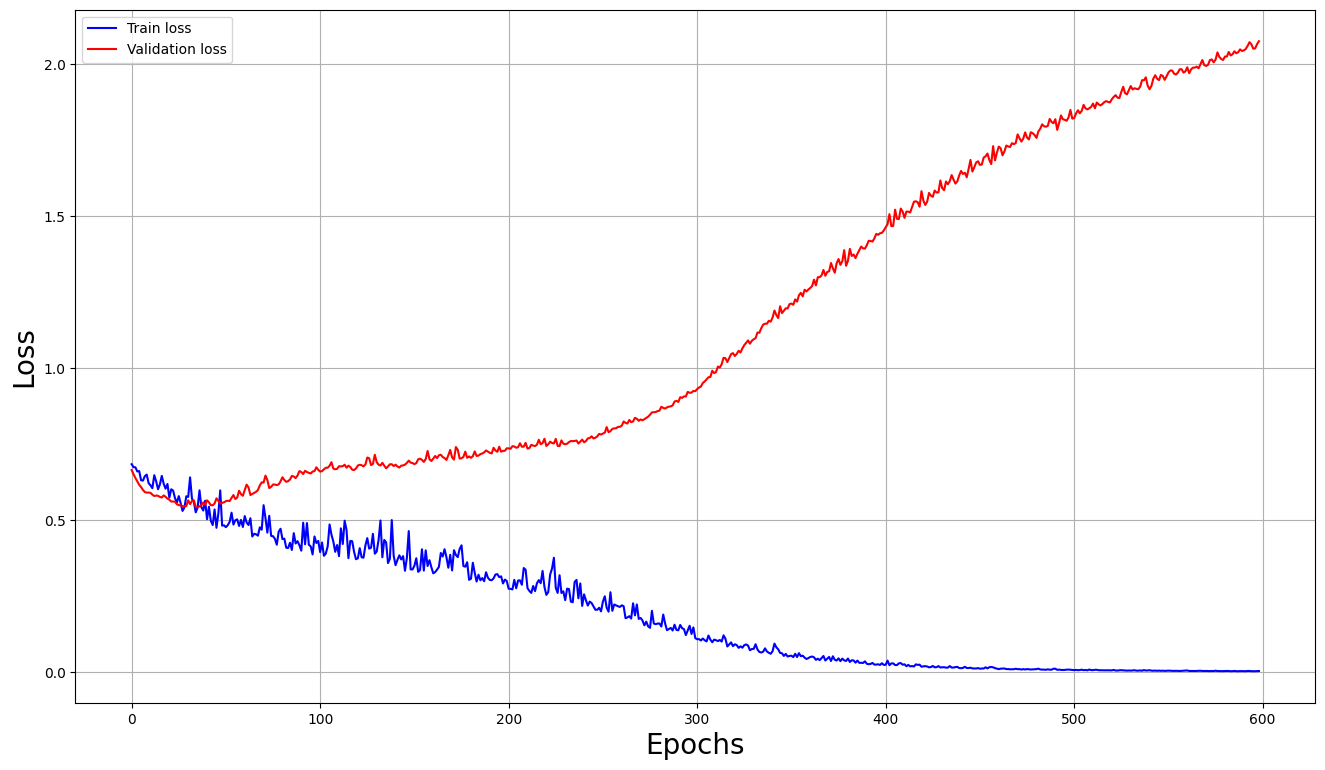

In [63]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

# Test Your Own MRI Scan! 🔬

Now you can upload and test your own MRI scan images to detect brain tumors.

In [76]:
def predict_tumor(image_path):
    """
    Predict if an MRI scan contains a brain tumor
    
    Args:
        image_path: Path to the MRI image file (jpg, png, etc.)
    
    Returns:
        prediction: "TUMOR DETECTED" or "HEALTHY"
        confidence: Probability score (0-1)
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"❌ Error: Could not load image from {image_path}")
        return None, None
    
    # Resize to 128x128
    img = cv2.resize(img, (128, 128))
    
    # Convert BGR to RGB
    b, g, r = cv2.split(img)
    img_rgb = cv2.merge([r, g, b])
    
    # Reshape for model: (channels, height, width)
    img_processed = img_rgb.reshape((img_rgb.shape[2], img_rgb.shape[0], img_rgb.shape[1]))
    
    # Convert to float32 and normalize
    img_processed = img_processed.astype(np.float32) / 255.0
    
    # Convert to tensor and add batch dimension
    img_tensor = torch.from_numpy(img_processed).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        confidence = output.item()
    
    # Determine result
    if confidence >= 0.5:
        prediction = "⚠️ TUMOR DETECTED"
    else:
        prediction = "✅ HEALTHY"
    
    # Display the image and result
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'{prediction}\nConfidence: {confidence:.2%}', fontsize=16, fontweight='bold')
    plt.show()
    
    print(f"\n{'='*50}")
    print(f"Prediction: {prediction}")
    print(f"Confidence Score: {confidence:.4f} ({confidence:.2%})")
    print(f"{'='*50}")
    
    return prediction, confidence

## How to Upload Your Own MRI Scan

### Method 1: Place file in project folder
1. Copy your MRI image to the project folder
2. Update the path in the code below
3. Run the prediction

### Method 2: Use full path
Simply provide the full path to your MRI scan:
```python
# Windows example:
predict_tumor("C:/Users/YourName/Downloads/my_mri_scan.jpg")

# Or with double backslashes:
predict_tumor("C:\\Users\\YourName\\Downloads\\my_mri_scan.jpg")
```

**Supported formats**: `.jpg`, `.jpeg`, `.png`, `.bmp`

## Option 1: Test with an image from your computer

Replace `'path/to/your/mri_scan.jpg'` with the actual path to your MRI image.

In [ ]:
# Example: Test with your own image
# Replace this path with the path to your MRI scan image
image_path = "path/to/your/mri_scan.jpg"

# Uncomment the line below to run the prediction
# predict_tumor(image_path)

## Option 2: Test with random images from the dataset

Testing with: ./data/brain_tumor_dataset/yes\Y102.jpg


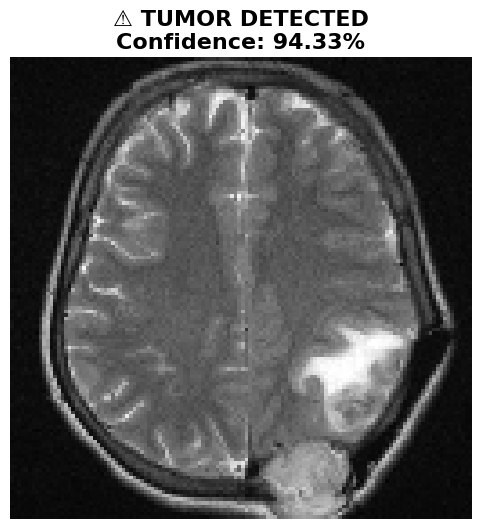


Prediction: ⚠️ TUMOR DETECTED
Confidence Score: 0.9433 (94.33%)


('⚠️ TUMOR DETECTED', 0.9432829022407532)

In [77]:
# Test with a random tumor image from the dataset
import random

tumor_images = glob.glob("./data/brain_tumor_dataset/yes/*.jpg")
random_tumor = random.choice(tumor_images)
print(f"Testing with: {random_tumor}")
predict_tumor(random_tumor)

Testing with: ./data/brain_tumor_dataset/no\No20.jpg


C:\Users\utk1r\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


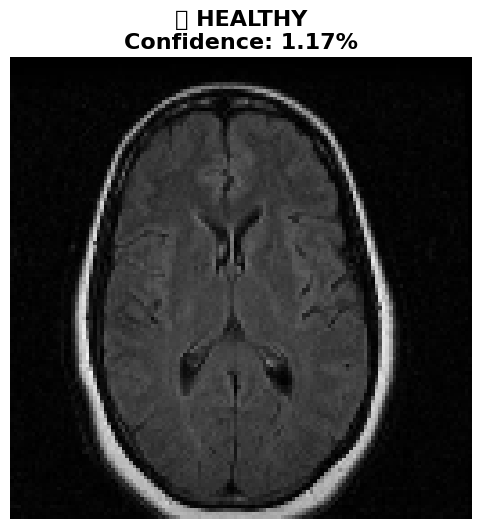


Prediction: ✅ HEALTHY
Confidence Score: 0.0117 (1.17%)


('✅ HEALTHY', 0.011651587672531605)

In [78]:
# Test with a random healthy image from the dataset
healthy_images = glob.glob("./data/brain_tumor_dataset/no/*.jpg")
random_healthy = random.choice(healthy_images)
print(f"Testing with: {random_healthy}")
predict_tumor(random_healthy)

## Option 3: Test with your own MRI scan from C:\Users\utk1r

In [79]:
# Let's check what image files are available in your user directory
user_path = r"C:\Users\utk1r"

# Search for common image formats
print("🔍 Searching for MRI images in your directory...\n")

image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
found_images = []

for ext in image_extensions:
    pattern = os.path.join(user_path, '**', ext)
    images = glob.glob(pattern, recursive=True)
    found_images.extend(images)

# Show first 10 images found
if found_images:
    print(f"✅ Found {len(found_images)} image(s):\n")
    for idx, img_path in enumerate(found_images[:10], 1):
        print(f"{idx}. {img_path}")
    
    if len(found_images) > 10:
        print(f"\n... and {len(found_images) - 10} more images")
    
    print("\n📝 Copy one of the paths above and use it in the next cell!")
else:
    print("❌ No image files found in C:\\Users\\utk1r")
    print("💡 Please place your MRI scan image in this directory or provide the full path.")

🔍 Searching for MRI images in your directory...

✅ Found 7985 image(s):

1. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\christopher-jolly.jpg
2. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\dan-meyers.jpg
3. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\daniel-meyer.jpg
4. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\davide-longo.jpg
5. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\denver-saldanha.jpg
6. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\fabrizio-conti.jpg
7. C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User Data\aoojcmojmmcbpfgoecoadbdpnagfchel\1.0.20\hans-muelders.jpg
8. C:\Users\utk1r\AppData\Loc

In [81]:
# 🧠 Test with your specific image path
# Replace the path below with one from the list above or provide your own

your_image_path = r" C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User"  # ⬅️ EDIT THIS PATH

predict_tumor(your_image_path)

❌ Error: Could not load image from  C:\Users\utk1r\AppData\Local\BraveSoftware\Brave-Browser\User


(None, None)

# Save the Trained Model for Web App 💾

Save your trained model to use it in the web application!

In [ ]:
# Save the trained model for the web app
torch.save(model.state_dict(), 'brain_tumor_model.pth')
print("✅ Model saved successfully as 'brain_tumor_model.pth'")
print("📁 Location:", os.path.abspath('brain_tumor_model.pth'))
print("\n🌐 You can now run the web app with: python app.py")

✅ Model saved successfully as 'brain_tumor_model.pth'
📁 Location: c:\Users\utk1r\Downloads\MLDawn-Projects-main\MLDawn-Projects-main\Pytorch\Brain-Tumor-Detector\brain_tumor_model.pth

🌐 You can now run the web app with: python app.py


: 